In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece

In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=5f72e898ad1694a974d49c3c2dd425f65edd6b5637aa1ad38c4f0d00134f6fe1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import custom module

In [4]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [79]:
from medqadataset import MedQADataset
import trainer
#from trainer import Trainer

In [80]:
# For debugging
import importlib
importlib.reload(trainer)

<module 'trainer' from '/content/drive/MyDrive/ITMO/T5QA/src/trainer.py'>

In [24]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel3"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
DEVICE

'cpu'

### Read Data

In [25]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_clean.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer,answer_start
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...,9
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...,9
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю...",2551
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...,4573
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери...",9
...,...,...,...,...
1108,есть ли у вас информация об измерении темпера...,измерение температуры тела может помочь обнару...,измерение температуры тела может помочь обнар...,-1
1109,что такое дефицит аденозинмонофосфатдезаминаз...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит аденозинмонофосфат амф дезаминазы это ...,12
1110,сколько людей страдают от дефицита аденозинмо...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит амфдезаминазы является одним из наибол...,174
1111,"каковы генетические изменения, связанные с де...",дефицит аденозинмонофосфатдезаминазы амф это ...,мутации в гене ampd1 вызывают дефицит ampдезам...,1495


### Example

In [44]:
sample = data.iloc[0]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=32,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [45]:
labels = TOKENIZER.decode(labels.flatten(), skip_special_tokens=True)

In [46]:
sample["answer"]

'кератодермия с пушистыми волосами представляет собой группу связанных состояний, которые поражают кожу и волосы и во многих случаях повышают риск потенциально опасных для жизни проблем с сердцем. у людей с такими заболеваниями волосы необычно грубые, сухие, тонкие и туго завитые. в некоторых случаях волосы также редкие. шерстистая текстура волос обычно поражает только волосы на коже головы и присутствует с рождения. начиная с раннего возраста, у пораженных людей также развивается ладонноподошвенная кератодермия состояние, при котором кожа на ладонях рук и подошвах ног становится толстой, чешуйчатой \u200b\u200bи мозолистой. кардиомиопатия, заболевание сердечной мышцы, представляет собой опасную для жизни проблему со здоровьем, которая может развиться у людей с кератодермией и пушистыми волосами. в отличие от других особенностей этого состояния, признаки и симптомы кардиомиопатии могут не проявляться до подросткового возраста или позже. осложнения кардиомиопатии могут включать нарушени

In [47]:
labels

'кератодермия с пушистыми волосами представляет собой группу связанных состояний, которые поражают кожу и волос'

In [48]:
output.loss

tensor(1.5536, grad_fn=<NllLossBackward0>)

In [49]:
sample_q = data.iloc[0]["question"]
sample_a = data.iloc[0]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [50]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [51]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [52]:
" ".join(preds)

'что тако е  кера то дерм ия с пуш исты ми волос ами ?   кера то дерм ия с пуш исты ми волос ами представля ет с обой групп у связ анных состояни й ,  которые пора жают кож у  и волос ы  и во мног их случа ях по выш ают риск потенци ально опас ных  для жизни проблем с серд цем . у люд ей с так ими заболевани ями волос ы не обычн о  груб ые , сух ие , тон кие  и ту го зави тые . в не которы х случа ях волос ы так же ред кие . шер сти стая текст ура волос  обычн о пора жает  только волос ы на кож е голов ы  и присут ствует с  рождени я . начина я с ран него возраст а , у по ражен ных люд ей так же развива ется лад онно по дош вен ная  кера то дерм ия состояни е , при котор ом кожа на  ладо нях рук  и по дош вах  ног станов ится тол стой ,  чеш уй чат ой  и моз оли стой . кардио ми опати я , заболевани е  сердеч ной мыш цы , представля ет с обой опас ную  для жизни проблем у со здоровь ем , котор ая  может раз виться у люд ей с  кера то дерм ией  и пуш исты ми волос ами . в от личие от др

### Dataloaders

In [32]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (872, 4)
Validation shape: (218, 4)
Test shape: (23, 4)


### Train and validation loop

In [81]:
N_EPOCHS = 100
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel3'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 0		Train loss: 7.016373126878651		Validation loss: 2.3615150755101983


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 1		Train loss: 3.3960999720687166		Validation loss: 1.7168846878138455


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 2		Train loss: 2.661731048461494		Validation loss: 1.5555862871083346


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 3		Train loss: 2.360789400175077		Validation loss: 1.3750935153527692


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 4		Train loss: 2.1427760928049002		Validation loss: 1.3211386490951884


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 5		Train loss: 1.9717522679118935		Validation loss: 1.203144223581661


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 6		Train loss: 1.847736416606728		Validation loss: 1.167675848982551


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 7		Train loss: 1.756336672863829		Validation loss: 1.0729331054470757


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 8		Train loss: 1.6561887436503664		Validation loss: 1.038423918052153


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 9		Train loss: 1.5884226951577247		Validation loss: 0.9876343786716462


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 10		Train loss: 1.501112841411468		Validation loss: 0.9787870762023059


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch: 11		Train loss: 1.4531734662318447		Validation loss: 0.8676019099625674


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch: 12		Train loss: 1.3672378149327882		Validation loss: 0.8429842003367164


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 13		Train loss: 1.3367681726129776		Validation loss: 0.8125459637154232


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 14		Train loss: 1.2618366237900673		Validation loss: 0.7737625584006309


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 15		Train loss: 1.2317714542150497		Validation loss: 0.7394590152935548


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch: 16		Train loss: 1.1760119026133773		Validation loss: 0.7073039877143773


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 17		Train loss: 1.1208988347458184		Validation loss: 0.6809544379060919


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 18		Train loss: 1.0882178606516724		Validation loss: 0.6421917565844276


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 19		Train loss: 1.0474738492331375		Validation loss: 0.6243547713214701


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 20		Train loss: 1.005937987784727		Validation loss: 0.5904996573925019


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch: 21		Train loss: 0.9817934256354603		Validation loss: 0.5581791234287349


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 22		Train loss: 0.9493187270853498		Validation loss: 0.5358443449844014


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 23		Train loss: 0.9153839173393512		Validation loss: 0.5067341804504395


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 24		Train loss: 0.8911329873521393		Validation loss: 0.4887789546088739


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 25		Train loss: 0.8472283140098283		Validation loss: 0.44827344221147625


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 26		Train loss: 0.8012247503897466		Validation loss: 0.43442924483255907


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 27		Train loss: 0.7831716166313635		Validation loss: 0.39953811358321795


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 28		Train loss: 0.7394674301420877		Validation loss: 0.38175388205457816


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 29		Train loss: 0.7333991496114556		Validation loss: 0.34817520607770847


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 30		Train loss: 0.6786868645373835		Validation loss: 0.33678333688188683


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 31		Train loss: 0.6622114128202473		Validation loss: 0.30449923541058194


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 32		Train loss: 0.6406802033339072		Validation loss: 0.2887589044191621


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch: 33		Train loss: 0.6003301253696101		Validation loss: 0.2619425811889497


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch: 34		Train loss: 0.5716920935232704		Validation loss: 0.2550882634791461


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 35		Train loss: 0.5527737256857234		Validation loss: 0.22402521026405423


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 36		Train loss: 0.524507232864789		Validation loss: 0.20969609970396216


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 37		Train loss: 0.5036992791595809		Validation loss: 0.18768135590309445


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 38		Train loss: 0.4747566448849276		Validation loss: 0.1867657953280617


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 39		Train loss: 0.45431306978704733		Validation loss: 0.16319265595891258


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 40		Train loss: 0.4209287616193568		Validation loss: 0.154988224753602


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 41		Train loss: 0.40675739995246635		Validation loss: 0.14080272455784407


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 42		Train loss: 0.3822286089352511		Validation loss: 0.12732739763503725


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch: 43		Train loss: 0.3624053074371651		Validation loss: 0.11265571068295023


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 44		Train loss: 0.3460619931681714		Validation loss: 0.09845480537888679


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 45		Train loss: 0.32579200643054934		Validation loss: 0.09433334232731298


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch: 46		Train loss: 0.3113319884062907		Validation loss: 0.07864285963164135


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 47		Train loss: 0.29065619996928294		Validation loss: 0.06739234053741464


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch: 48		Train loss: 0.27269989017978175		Validation loss: 0.06462691772559827


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 49		Train loss: 0.2595604911890872		Validation loss: 0.05486350643702529


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch: 50		Train loss: 0.23980237989592443		Validation loss: 0.047681367341746494


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 51		Train loss: 0.23236140089297513		Validation loss: 0.04192263735458255


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 52		Train loss: 0.21994978710667257		Validation loss: 0.0386517718794163


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 53		Train loss: 0.21024843366867904		Validation loss: 0.0354534462295388


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 54		Train loss: 0.19351190330306872		Validation loss: 0.026983649299522353


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch: 55		Train loss: 0.18246328625657143		Validation loss: 0.02457245309117504


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 56		Train loss: 0.17391982740389372		Validation loss: 0.022952449476261707


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch: 57		Train loss: 0.16462273766722427		Validation loss: 0.019547783079377205


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch: 58		Train loss: 0.158390792701906		Validation loss: 0.0171981972520536


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch: 59		Train loss: 0.1438447203179565		Validation loss: 0.012895204620012505


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch: 60		Train loss: 0.13670548501877336		Validation loss: 0.012270324895243075


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 61		Train loss: 0.13381354026325526		Validation loss: 0.010368240555875341


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch: 62		Train loss: 0.1274188597421717		Validation loss: 0.008820866508771856


Training batches:  98%|█████████▊| 213/218 [02:37<00:03,  1.35it/s]

### Evaluate the results

In [88]:
test_sample = test_data.iloc[3]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"{test_sample['answer']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question,
   test_answer,
   print_text=True
)

pred

Контекст: боль в половом члене это любая боль или дискомфорт в половом члене. причины причины могут включать в себя: камни в мочевом пузыре. укусы человека или насекомых. рак полового члена. непроходящая эрекция приапизм. генитальный герпес. инфицированные волосяные фолликулы. инфицированный протез полового члена. инфекция под крайней плотью у необрезанных мужчин баланит. воспаление предстательной железы простатиттравма болезнь пейрони синдром рейтерасерповидноклеточная анемиясифилисуретрит, вызванный хламидиями или гонореей инфекция мочевого пузыря тромб в вене полового члена перелом полового члена уход на дому как лечить боль в половом члене дома зависит от ее причины. поговорите со своим врачом о лечении. пакеты со льдом могут помочь облегчить боль. не прикладывайте лед непосредственно к пенису. вместо этого поместите лед в полотенце или мочалку и приложите завернутый лед, чтобы облегчить боль. если боль в половом члене вызвана заболеванием, передающимся половым путем, важно, чтобы 

{'Reference Answer: ': 'причинами могут быть: камни в мочевом пузыре укусы человека или насекомых рак полового члена непроходящая эрекция приапизм генитальный герпес инфицированные волосяные фолликулы инфицированный протез полового члена инфекция под крайней плотью у необрезанных мужчин баланит воспаление предстательной железы простатит травма болезнь пейрони синдром рейтера серповидноклеточная анемия сифилис уретрит, вызванный хламидиями или гонореей',
 'Predicted Answer: ': 'Ответ: причинами могут быть: камни в мочевом пузыре',
 'BLEU Score: ': {'google_bleu': 0.1262135922330097},
 'RougeL (precision): ': 0}

In [67]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.14117568971024988
RougeL: 0.06521739130434782


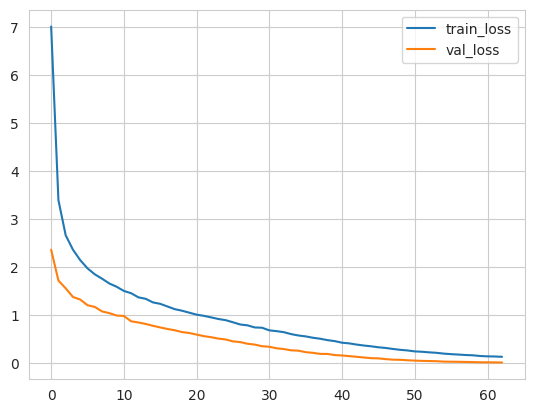

In [103]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/t5_MedQAD_loss_63.csv"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [94]:
test_sample = test_data.iloc[12]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что вызывает отек лица? также называется: одутловатое лицо; отек лица; лунное лицо; отек лица
Контекст: отек лица это скопление жидкости в тканях лица. отек также может возникнуть на шее и плечах. соображения если отек лица легкий, его может быть трудно обнаружить. сообщите врачу следующее: боль и места, где она болит. как долго сохраняется отек. что делает его лучше или хуже? если у вас есть другие симптомы. причины причины отека лица могут включать в себя: аллергическую реакцию аллергический ринит, сенная лихорадка или укус пчелы. отек квинке реакция на переливание крови целлюлит конъюнктивит воспаление глаз реакция на лекарства, в том числе вызванные аспирином, пенициллином, сульфаниламидами, глюкокортикоидами и др. операции на голове, носу или челюсти травма или травма лица например, ожог недоедание в тяжелых случаях ожирение слюны заболевания желез синусит ячмень с отеком вокруг инфицированного глаза абсцесс зуба уход на дому применяйте холодные компрессы, чтобы уменьшить

In [97]:
test_sample = test_data.iloc[15]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое путаница? также называется: дезориентация; мышление неясное; мысли затуманенное
Контекст: замешательство это неспособность думать так ясно и быстро, как обычно. вы можете чувствовать дезориентацию и испытывать трудности с концентрацией внимания, запоминанием и принятием решений. соображения замешательство может нарастать быстро или медленно с течением времени, в зависимости от причины. во многих случаях спутанность сознания длится недолго и проходит. в других случаях это навсегда и неизлечимо. это может быть связано с бредом или деменцией. спутанность сознания чаще встречается у пожилых людей и часто возникает во время пребывания в больнице. некоторые люди с растерянностью могут вести себя странно или необычно или вести себя агрессивно. причины спутанность сознания может быть вызвана различными проблемами со здоровьем, например :алкогольная или наркотическая интоксикация опухоль головного мозга травма головы или травма головы сотрясение мозгалихорадкадисбаланс жидкос

In [99]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  каковы симптомы дивертикулеза? также называется: дивертикула дивертикулез; дивертикулит дивертикулез; дивертикулярная болезнь дивертикулез; желудочнокишечное кровотечение дивертикулез; желудочнокишечное кровотечение дивертикулез; желудочнокишечное кровотечение дивертикулез
Контекст: дивертикулез возникает, когда на внутренней стенке кишечника образуются маленькие выпуклые мешочки или мешочки. эти мешочки называются дивертикулами. чаще всего эти мешочки образуются в толстой кишке толстой кишке. они также могут возникать в тощей кишке и тонкой кишке, хотя это встречается реже. причины дивертикулез реже встречается у людей в возрасте 40 лет и моложе. это чаще встречается у пожилых людей. около половины американцев старше 60 лет страдают этим заболеванием. у большинства людей это случается к 80 годам. никто точно не знает, что вызывает образование этих мешочков. в течение многих лет считалось, что диета с низким содержанием клетчатки может сыграть свою роль. недостаток клетчатки м

In [104]:
test_sample = test_data.iloc[9]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что вызывает абсцесс?
Контекст: абсцесс это скопление гноя в любой части тела. в большинстве случаев область вокруг абсцесса опухает и воспаляется. причины абсцессы возникают, когда участок ткани заражается, и иммунная система организма пытается бороться с ним и сдерживать его. лейкоциты лейкоциты перемещаются через стенки кровеносных сосудов в область инфекции и собираются в поврежденной ткани. в ходе этого процесса образуется гной. гной это скопление жидкости, живых и мертвых лейкоцитов, мертвых тканей, бактерий или других посторонних веществ. абсцессы могут образовываться практически в любой части тела. кожа, под кожей и зубы являются наиболее распространенными местами. абсцессы могут быть вызваны бактериями, паразитами и инородными веществами. абсцессы на коже легко увидеть. они красные, приподнятые и болезненные. абсцессы в других частях тела могут быть не видны, но они могут вызывать повреждение органов. некоторые типы и локализации абсцессов включают: абдоминальный абсц